In [163]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree

df1= pd.read_csv(r"C:\Users\Tusha\Visual Studio Codes\test_codeEVT\smoothen_data\car_smooth.csv").tail(20000)
df2= pd.read_csv(r"C:\Users\Tusha\Visual Studio Codes\test_codeEVT\smoothen_data/ped_smooth.csv").tail(20000)
common_pairs = []



In [ ]:
# Parameters
min_stop_duration = 1.0  # seconds
speed_threshold = 0.2  # m/s (adjust based on sensor noise)

# 1. Calculate time differences within each track
df1['time_diff'] = df1.groupby('Track ID')['TimeStamp'].diff()

# 2. Identify stop segments (where speed < threshold)
df1['is_stopped'] = df1['speed'] < speed_threshold

# 3. Group consecutive stops and calculate cumulative stop duration
stop_groups = (df1['is_stopped'] != df1['is_stopped'].shift()).cumsum()
df1['stop_duration'] = df1.groupby(['Track ID', stop_groups])['time_diff'].cumsum()

# 4. Filter out only sustained stops (>1 second)
filtered_df = df1[~((df1['is_stopped']) & (df1['stop_duration'] >= min_stop_duration))]

print(f"Original rows: {len(df1)}")
print(f"Filtered rows: {len(filtered_df)}")
filtered_df

Original rows: 20000
Filtered rows: 10074


In [165]:
df1=filtered_df
for car_id in df1['Track ID'].unique():
    car_times = set(df1[df1['Track ID'] == car_id]['TimeStamp'])
    
    for ped_id in df2['Track ID'].unique():
        ped_times = set(df2[df2['Track ID'] == ped_id]['TimeStamp'])
        
        if car_times & ped_times:  # If timestamps overlap
            common_pairs.append((car_id, ped_id))

if common_pairs:
    car_id, ped_id = common_pairs[np.random.choice(len(common_pairs))]
else:
    raise ValueError("No overlapping car-pedestrian tracks found!")

car_data = df1[df1['Track ID'] == 191]
ped_data = df2[df2['Track ID'] == 292]

# Load data
df_car = car_data
df_ped = ped_data

# Thresholds
DIST_THRESH = 3.5  # meters
TIME_THRESH = 1.0   # seconds

# Prepare data - ensure these columns exist in your data
car_data = df_car[['Track ID', 'x_smooth', 'y_smooth', 'TimeStamp']].values
ped_data = df_ped[['Track ID', 'x_smooth', 'y_smooth', 'TimeStamp']].values

# Build KDTree for pedestrian points
ped_tree = cKDTree(ped_data[:, 1:3])  # Use only X,y_smooth coordinates

# Find all close encounters
close_encounters = []
for i, car in enumerate(car_data):
    car_id, car_x, car_y, car_time = car
    dist, ped_idx = ped_tree.query([car_x, car_y], distance_upper_bound=DIST_THRESH)
    
    if dist < DIST_THRESH:
        ped_id, ped_x, ped_y, ped_time = ped_data[ped_idx]
        time_diff = abs(car_time - ped_time)
        
        if time_diff <= TIME_THRESH:
            close_encounters.append({
                'Car_Track_ID': car_id,
                'Ped_Track_ID': ped_id,
                'Car_X': car_x,
                'Car_Y': car_y,
                'Car_Time': car_time,
                'Ped_X': ped_x,
                'Ped_Y': ped_y,
                'Ped_Time': ped_time,
                'Distance': dist,
                'Time_Difference': time_diff
            })

# Convert to DataFrame
results_df = pd.DataFrame(close_encounters)


# Save and display results
if not results_df.empty:
    # results_df.to_csv("dangerous_encounters.csv", index=False)
    print(f"Found {len(results_df)} dangerous encounters:")
    print(results_df[['Car_Track_ID', 'Ped_Track_ID', 'Distance', 'Time_Difference']].head())
else:
    print("No dangerous encounters found")

No dangerous encounters found


Optimised Code Trial__1

In [ ]:
# Load data
df_ped = pd.read_csv(r"C:\Users\Tusha\Visual Studio Codes\test_codeEVT\smoothen_data/ped_smooth.csv")
df_car = pd.read_csv(r"C:\Users\Tusha\Visual Studio Codes\test_codeEVT\smoothen_data\car_smooth.csv")
min_stop_duration = 1.0  # seconds
speed_threshold = 0.08  # m/s (adjust based on sensor noise)

# 1. Calculate time differences within each track
df_car['time_diff'] = df_car.groupby('Track ID')['TimeStamp'].diff()

# 2. Identify stop segments (where speed < threshold)
df_car['is_stopped'] = df_car['speed'] < speed_threshold

# 3. Group consecutive stops and calculate cumulative stop duration
stop_groups = (df_car['is_stopped'] != df_car['is_stopped'].shift()).cumsum()
df_car['stop_duration'] = df_car.groupby(['Track ID', stop_groups])['time_diff'].cumsum()

# 4. Filter out only sustained stops (>1 second)
filtered_df = df_car[~((df_car['is_stopped']) & (df_car['stop_duration'] >= min_stop_duration))]

print(f"Original rows: {len(df_car)}")
print(f"Filtered rows: {len(filtered_df)}")
df_car=filtered_df
# Parameters
# LC_Car=1.5
# W_Ped=0.3
# W_Car
DIST_THRESH = 1.62  # meters
TIME_THRESH = 1

# Storage for unique pairs
interaction_pairs = set()

# Process each pedestrian
for ped_id in df_ped['Track ID'].unique():
    # Get smoothed coordinates and timestamps
    ped_data = df_ped[df_ped['Track ID'] == ped_id]
    ped_points = ped_data[['x_smooth', 'y_smooth', 'TimeStamp']].values
    
    # Time window for active cars
    time_min = ped_points[:,2].min() - TIME_THRESH
    time_max = ped_points[:,2].max() + TIME_THRESH
    active_cars = df_car[(df_car['TimeStamp'] >= time_min) & 
                         (df_car['TimeStamp'] <= time_max)]
    
    if not active_cars.empty:
        # Build KDTree with smoothed coordinates
        car_points = active_cars[['x_smooth', 'y_smooth', 'TimeStamp']].values
        tree = cKDTree(car_points[:,:2])  # Only x_smooth and y_smooth
        
        # Check each pedestrian point
        for ped_x, ped_y, ped_time in ped_points:
            # Find nearby cars (within 3.5m)
            distances, indices = tree.query(
                [ped_x, ped_y],
                distance_upper_bound=DIST_THRESH,
                k=10  # Check up to 10 nearest cars
            )
            
            # Verify time proximity (within 5s)
            for dist, idx in zip(distances, indices):
                if dist < DIST_THRESH:
                    car_time = car_points[idx,2]
                    if abs(car_time - ped_time) <= TIME_THRESH:
                        car_id = active_cars.iloc[idx]['Track ID']
                        interaction_pairs.add((ped_id, car_id))

# Create result DataFrame
result = pd.DataFrame(
    sorted(interaction_pairs),
    columns=['Pedestrian_ID', 'Car_ID']
)

print(f"Found {len(result)} unique interaction pairs")
# result.to_csv("ped_car_interactions.csv", index=False)
print(result.head (20))

Original rows: 329613
Filtered rows: 174448
Found 184 unique interaction pairs
    Pedestrian_ID  Car_ID
0             382     374
1             391     374
2            1285    1348
3            1312    1133
4            1419    1469
5            1524    1559
6            1638    1374
7            1668    1553
8            1692    1553
9            1692    1855
10           1752    1553
11           1902    1966
12           2061    2127
13           2116    2127
14           2116    2161
15           2185    2156
16           2190    2081
17           2190    2096
18           2234    2239
19           2809    2829


In [179]:
# Load data
df_ped = pd.read_csv(r"C:\Users\Tusha\Visual Studio Codes\test_codeEVT\smoothen_data/ped_smooth.csv")
df_tuktuk = pd.read_csv(r"C:\Users\Tusha\Visual Studio Codes\test_codeEVT\smoothen_data\tuktuk_smooth.csv")
min_stop_duration = 1.0  # seconds
speed_threshold = 0.2  # m/s (adjust based on sensor noise)

# 1. Calculate time differences within each track
df_tuktuk['time_diff'] = df_tuktuk.groupby('Track ID')['TimeStamp'].diff()

# 2. Identify stop segments (where speed < threshold)
df_tuktuk['is_stopped'] = df_tuktuk['speed'] < speed_threshold

# 3. Group consecutive stops and calculate cumulative stop duration
stop_groups = (df_tuktuk['is_stopped'] != df_tuktuk['is_stopped'].shift()).cumsum()
df_tuktuk['stop_duration'] = df_tuktuk.groupby(['Track ID', stop_groups])['time_diff'].cumsum()

# 4. Filter out only sustained stops (>1 second)
filtered_df = df_tuktuk[~((df_tuktuk['is_stopped']) & (df_tuktuk['stop_duration'] >= min_stop_duration))]

print(f"Original rows: {len(df_tuktuk)}")
print(f"Filtered rows: {len(filtered_df)}")
df_tuktuk=filtered_df
# Parameters
# LC_Car=1.5
# W_Ped=0.3
# W_Car
DIST_THRESH = 1  # meters
TIME_THRESH = 0.5   # seconds (changed from 1.0 to 5.0)

# Storage for unique pairs
interaction_pairs = set()

# Process each pedestrian
for ped_id in df_ped['Track ID'].unique():
    # Get smoothed coordinates and timestamps
    ped_data = df_ped[df_ped['Track ID'] == ped_id]
    ped_points = ped_data[['x_smooth', 'y_smooth', 'TimeStamp']].values
    
    # Time window for active cars
    time_min = ped_points[:,2].min() - TIME_THRESH
    time_max = ped_points[:,2].max() + TIME_THRESH
    active_cars = df_tuktuk[(df_tuktuk['TimeStamp'] >= time_min) & 
                         (df_tuktuk['TimeStamp'] <= time_max)]
    
    if not active_cars.empty:
        # Build KDTree with smoothed coordinates
        tuktuk_points = active_cars[['x_smooth', 'y_smooth', 'TimeStamp']].values
        tree = cKDTree(tuktuk_points[:,:2])  # Only x_smooth and y_smooth
        
        # Check each pedestrian point
        for ped_x, ped_y, ped_time in ped_points:
            # Find nearby cars (within 3.5m)
            distances, indices = tree.query(
                [ped_x, ped_y],
                distance_upper_bound=DIST_THRESH,
                k=10  # Check up to 10 nearest cars
            )
            
            # Verify time proximity (within 5s)
            for dist, idx in zip(distances, indices):
                if dist < DIST_THRESH:
                    car_time = tuktuk_points[idx,2]
                    if abs(car_time - ped_time) <= TIME_THRESH:
                        tuktuk_id = active_cars.iloc[idx]['Track ID']
                        interaction_pairs.add((ped_id, tuktuk_id))

# Create result DataFrame
result = pd.DataFrame(
    sorted(interaction_pairs),
    columns=['Pedestrian_ID', 'tuktuk_ID']
)

print(f"Found {len(result)} unique interaction pairs")
# result.to_csv("ped_car_interactions.csv", index=False)
print(result.head(10))

Original rows: 379048
Filtered rows: 226691
Found 220 unique interaction pairs
   Pedestrian_ID  tuktuk_ID
0            369        368
1            381        372
2            382        368
3            382        372
4            382        392
5            391        389
6            391        392
7            408        403
8            415        456
9            425        456


# moto Test 1

In [6]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist

# Load data
df_ped = pd.read_csv(r"D:\T\test_codeEVT\nd\ped_smooth.csv").tail(5000)
df_moto = pd.read_csv(r"D:\T\test_codeEVT\nd\moto_smooth.csv").tail(5000)
df_moto['speed']=(df_moto['vx_smooth']**2+df_moto['vy_smooth']**2)**0.5
# Parameters for vehicle stop filtering
SPEED_THRESHOLD = 0.5  # m/s (adjust as needed)
MIN_STOP_DURATION = 1.0  # seconds

def filter_stopped_vehicles(df, speed_col='speed', time_col='TimeStamp'):
    """Filter out periods where vehicles are stopped for more than MIN_STOP_DURATION"""
    # Calculate time differences within each track
    df['time_diff'] = df.groupby('Track ID')[time_col].diff()
    
    # Identify stop segments (where speed < threshold)
    df['is_stopped'] = df[speed_col] < SPEED_THRESHOLD
    
    # Group consecutive stops and calculate cumulative stop duration
    stop_groups = (df['is_stopped'] != df['is_stopped'].shift()).cumsum()
    df['stop_duration'] = df.groupby(['Track ID', stop_groups])['time_diff'].cumsum()
    
    # Filter out only sustained stops (> MIN_STOP_DURATION seconds)
    filtered_df = df[~((df['is_stopped']) & (df['stop_duration'] >= MIN_STOP_DURATION))]
    
    # Clean up temporary columns
    filtered_df = filtered_df.drop(columns=['time_diff', 'is_stopped', 'stop_duration'])
    
    return filtered_df

# Only filter stopped vehicles (motorcycles), keep all pedestrian data
print(f"Original motorcycle count: {len(df_moto)}")
df_moto = filter_stopped_vehicles(df_moto, speed_col='speed')
print(f"Filtered motorcycle count: {len(df_moto)}")

# Round to nearest 0.16s (export interval)
EXPORT_INTERVAL = 0.16
df_ped['TimeStamp_rounded'] = np.round(df_ped['TimeStamp'] / EXPORT_INTERVAL) * EXPORT_INTERVAL
df_moto['TimeStamp_rounded'] = np.round(df_moto['TimeStamp'] / EXPORT_INTERVAL) * EXPORT_INTERVAL

# Time buffer for matching
TIME_BUFFER = 0.0  # ±1 export frame

# Calculate heading angles from velocity vectors (in degrees)
def calculate_heading(vx, vy):
    return np.degrees(np.arctan2(vy, vx)) % 360

df_ped['heading'] = calculate_heading(df_ped['vx_smooth'], df_ped['vy_smooth'])
df_moto['heading'] = calculate_heading(df_moto['vx_smooth'], df_moto['vy_smooth'])

# Bounding box dimensions
PED_BOX = (0.3, 0.3)  # (length, width)
MOTO_BOX = (1.87, 0.64)

# Distance threshold
DIST_THRESH = 0.9882433

def get_rotated_corners(x, y, heading, length, width):
    """Calculate rotated bounding box corners"""
    half_l = length / 2
    half_w = width / 2
    
    corners = np.array([
        [ half_l,  half_w],  # Front right
        [ half_l, -half_w],  # Front left
        [-half_l, -half_w],  # Rear left
        [-half_l,  half_w]   # Rear right
    ])
    
    rad = np.radians(heading)
    rot_mat = np.array([
        [np.cos(rad), -np.sin(rad)],
        [np.sin(rad),  np.cos(rad)]
    ])
    
    rotated = np.dot(corners, rot_mat.T) + np.array([x, y])
    return rotated

def calculate_closing_rate(ped_row, moto_row):
    """Calculate closing rate using vector projection method"""
    # Relative position vector (pedestrian to moto)
    rel_x = ped_row['x_smooth'] - moto_row['x_smooth']
    rel_y = ped_row['y_smooth'] - moto_row['y_smooth']
    distance = np.hypot(rel_x, rel_y)
    
    if distance == 0:
        return 0  # Collision already occurring
    
    # Unit vector in direction of shortest distance
    u_x = rel_x / distance
    u_y = rel_y / distance
    
    # Relative velocity components
    rel_vx = ped_row['vx_smooth'] - moto_row['vx_smooth']
    rel_vy = ped_row['vy_smooth'] - moto_row['vy_smooth']
    
    # Closing rate is negative dot product (positive when closing)
    closing_rate = -(rel_vx * u_x + rel_vy * u_y)
    return closing_rate

# Get all unique pedestrian and motorcycle IDs
ped_ids = df_ped['Track ID'].unique()
moto_ids = df_moto['Track ID'].unique()

all_conflicts = []

# Iterate through all pedestrian-motorcycle pairs
for ped_id in ped_ids:
    ped = df_ped[df_ped['Track ID'] == ped_id].copy()
    
    for moto_id in moto_ids:
        moto = df_moto[df_moto['Track ID'] == moto_id].copy()
        
        conflicts = []
        
        for _, ped_row in ped.iterrows():
            # Temporal proximity check using rounded timestamps
            time_window = (ped_row['TimeStamp_rounded'] - TIME_BUFFER, 
                          ped_row['TimeStamp_rounded'] + TIME_BUFFER)
            
            moto_matches = moto[
                moto['TimeStamp_rounded'].between(*time_window) & 
                (abs(moto['TimeStamp_rounded'] - ped_row['TimeStamp_rounded']) <= TIME_BUFFER)
            ]
            
            for _, moto_row in moto_matches.iterrows():
                # Center-to-center distance check
                center_dist = np.hypot(moto_row['x_smooth'] - ped_row['x_smooth'],
                                      moto_row['y_smooth'] - ped_row['y_smooth'])
                
                if center_dist <= DIST_THRESH:
                    # Get precise bounding boxes
                    ped_corners = get_rotated_corners(
                        ped_row['x_smooth'], ped_row['y_smooth'],
                        ped_row['heading'], *PED_BOX
                    )
                    
                    moto_corners = get_rotated_corners(
                        moto_row['x_smooth'], moto_row['y_smooth'],
                        moto_row['heading'], *MOTO_BOX
                    )
                    
                    # Minimum corner-to-corner distance
                    dist_matrix = cdist(ped_corners, moto_corners)
                    min_dist = np.min(dist_matrix)
                    
                    # Calculate closing rate and determine encounter type
                    closing_rate = calculate_closing_rate(ped_row, moto_row)
                    
                    if closing_rate > 0:  # Closing - potential conflict
                        conflict_status = "Closing"
                        attc = min_dist / closing_rate
                    elif closing_rate < 0:  # Separating
                        conflict_status = "Separating"
                        attc = np.inf
                    else:  # Zero closing rate (parallel motion)
                        conflict_status = "Parallel"
                        attc = np.inf
                    
                    conflicts.append({
                        'Ped_ID': ped_id,
                        'Moto_ID': moto_id,
                        'Ped_Time': ped_row['TimeStamp'],
                        'Ped_Time_Rounded': ped_row['TimeStamp_rounded'],
                        'Moto_Time': moto_row['TimeStamp'],
                        'Moto_Time_Rounded': moto_row['TimeStamp_rounded'],
                        'Time_Diff': moto_row['TimeStamp_rounded'] - ped_row['TimeStamp_rounded'],
                        'Center_Distance': center_dist,
                        'Min_Corner_Distance': min_dist,
                        'Closing_Rate': closing_rate,
                        'ATTC': attc,
                        'Conflict_Status': conflict_status,
                        'Ped_X': ped_row['x_smooth'],
                        'Ped_Y': ped_row['y_smooth'],
                        'Moto_X': moto_row['x_smooth'],
                        'Moto_Y': moto_row['y_smooth'],
                        'Moto_Heading': moto_row['heading'],
                        'Ped_Heading': ped_row['heading']
                    })
        
        if conflicts:
            # Remove duplicate conflicts (same rounded timestamps)
            conflict_df = pd.DataFrame(conflicts).drop_duplicates(
                subset=['Ped_Time_Rounded', 'Moto_Time_Rounded'], 
                keep='first'
            )
            all_conflicts.append(conflict_df)

# Combine all conflicts into one DataFrame
if all_conflicts:
    results = pd.concat(all_conflicts, ignore_index=True)
    
    # Classify different types of encounters
    results['Encounter_Type'] = np.select(
        [
            results['Closing_Rate'] > 0,
            results['Closing_Rate'] < 0,
            results['Closing_Rate'] == 0
        ],
        [
            'Closing',
            'Separating',
            'Parallel'
        ],
        default='Unknown'
    )
    
    # Save all encounters
    results.to_csv("all_encounter_points.csv", index=False)
    
    # Filter for near-misses (closing cases with small ATTC and distance)
    near_miss = results[  
        (results['Min_Corner_Distance'] < 1.0)
    ]
    
    print("\nEncounter Type Distribution:")
    print(results['Encounter_Type'].value_counts())
    
    print(f"\nFound {len(near_miss)} near-miss events:")
    print(near_miss[['Ped_ID', 'Moto_ID', 'Ped_Time_Rounded', 
                    'Min_Corner_Distance', 'Closing_Rate', 'ATTC']].to_string())
    
    # Save near-miss events
    near_miss.to_csv("near_miss_events.csv", index=False)
    
    # Summary statistics
    print("\nSummary Statistics for Near-Miss Events:")
    print(f"Number of unique pedestrian IDs involved: {near_miss['Ped_ID'].nunique()}")
    print(f"Number of unique motorcycle IDs involved: {near_miss['Moto_ID'].nunique()}")
    print("\nATTC Statistics (seconds):")
    print(near_miss['ATTC'].describe())
else:
    print("No conflicts found between any pedestrian-motorcycle pairs")

Original motorcycle count: 5000
Filtered motorcycle count: 4393

Encounter Type Distribution:
Encounter_Type
Separating    23
Closing       18
Name: count, dtype: int64

Found 41 near-miss events:
    Ped_ID  Moto_ID  Ped_Time_Rounded  Min_Corner_Distance  Closing_Rate       ATTC
0    15693    15756           5396.32             0.490573      0.903015   0.543262
1    15693    15756           5396.48             0.640313      0.048383  13.234243
2    15693    15756           5396.64             0.645040     -0.774689        inf
3    15693    15756           5396.80             0.528405     -0.744687        inf
4    15693    15756           5396.96             0.512654     -0.503310        inf
5    15693    15756           5397.12             0.507103     -0.184518        inf
6    15693    15756           5397.28             0.268971      0.020377  13.199957
7    15693    15756           5397.44             0.344105      0.112054   3.070893
8    15693    15756           5397.60          

d:\C_drive_folders\Anaconda3\envs\Abhinav_IIT_Bhu\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [7]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist

# Parameters
SPEED_THRESHOLD = 0.5  # m/s
MIN_STOP_DURATION = 1.0  # seconds
DIST_THRESH = 0.9882433
EXPORT_INTERVAL = 0.16  # seconds

def filter_stopped_vehicles(df, speed_col='speed', time_col='TimeStamp'):
    """Filter out periods where vehicles are stopped for more than MIN_STOP_DURATION"""
    df = df.copy()
    df['time_diff'] = df.groupby('Track ID')[time_col].diff()
    df['is_stopped'] = df[speed_col] < SPEED_THRESHOLD
    stop_groups = (df['is_stopped'] != df['is_stopped'].shift()).cumsum()
    df['stop_duration'] = df.groupby(['Track ID', stop_groups])['time_diff'].cumsum()
    filtered_df = df[~((df['is_stopped']) & (df['stop_duration'] >= MIN_STOP_DURATION))]
    return filtered_df.drop(columns=['time_diff', 'is_stopped', 'stop_duration'])

# Load and filter data
df_ped = pd.read_csv(r"D:\T\test_codeEVT\nd\ped_smooth.csv")
df_moto = pd.read_csv(r"D:\T\test_codeEVT\nd\moto_smooth.csv")
df_moto['speed']=(df_moto['vx_smooth']**2+df_moto['vy_smooth']**2)**0.5

print(f"Original motorcycle count: {len(df_moto)}")
df_moto = filter_stopped_vehicles(df_moto, speed_col='speed')
print(f"Filtered motorcycle count: {len(df_moto)}")

# Calculate yaw rates (first entry per Track ID will be NaN)
for df in [df_ped, df_moto]:
    df['yaw_rate'] = df.groupby('Track ID').apply(
        lambda x: x['HA'].diff() / x['TimeStamp'].diff()
    ).reset_index(level=0, drop=True)

# Round timestamps
df_ped['Time_rounded'] = (df_ped['TimeStamp'] / EXPORT_INTERVAL).round() * EXPORT_INTERVAL
df_moto['Time_rounded'] = (df_moto['TimeStamp'] / EXPORT_INTERVAL).round() * EXPORT_INTERVAL

# Vectorized temporal matching
merged = pd.merge(
    df_ped, 
    df_moto, 
    on='Time_rounded', 
    suffixes=('_ped', '_moto')
)

# Vectorized center-distance calculation
merged['Center_dist'] = np.hypot(
    merged['x_smooth_ped'] - merged['x_smooth_moto'],
    merged['y_smooth_ped'] - merged['y_smooth_moto']
)

# Vectorized corner-distance calculation
def get_min_corner_distance(row, ped_box=(0.3, 0.3), moto_box=(1.87, 0.64)):
    ped_corners = get_rotated_corners(
        row['x_smooth_ped'], row['y_smooth_ped'],
        row['HA_ped'], *ped_box
    )
    moto_corners = get_rotated_corners(
        row['x_smooth_moto'], row['y_smooth_moto'],
        row['HA_moto'], *moto_box
    )
    return cdist(ped_corners, moto_corners).min()

# Vectorized ATTC calculation
def calculate_attc(row):
    # Relative position and velocity
    dx = row['x_smooth_ped'] - row['x_smooth_moto']
    dy = row['y_smooth_ped'] - row['y_smooth_moto']
    dvx = row['vx_smooth_ped'] - row['vx_smooth_moto']
    dvy = row['vy_smooth_ped'] - row['vy_smooth_moto']
    distance = np.hypot(dx, dy)
    
    if distance == 0:
        return np.inf
    
    # Closing rate components
    vel_component = -(dvx*dx + dvy*dy)/distance
    acc_component = ((row['ax_ped']-row['ax_moto'])*dx + 
                    (row['ay_ped']-row['ay_moto'])*dy)/distance * 0.5  # 0.5s prediction
    
    closing_rate = vel_component + acc_component
    min_dist = get_min_corner_distance(row)
    
    return min_dist/closing_rate if closing_rate > 0 else np.inf

# Apply filters and calculations
results = merged[merged['Center_dist'] <= DIST_THRESH].copy()
results['Min_Corner_Distance'] = results.apply(get_min_corner_distance, axis=1)
results['ATTC'] = results.apply(calculate_attc, axis=1)

# Final output
output = results[['Track ID_ped', 'Track ID_moto', 'TimeStamp_ped', 
                 'Min_Corner_Distance', 'ATTC']].rename(columns={
                     'Track ID_ped': 'Ped_ID',
                     'Track ID_moto': 'Moto_ID',
                     'TimeStamp_ped': 'TimeStamp'
                 })
print(output)

Original motorcycle count: 307259
Filtered motorcycle count: 200053


C:\Users\IST LAB 1\AppData\Local\Temp\ipykernel_15852\593482079.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['yaw_rate'] = df.groupby('Track ID').apply(
C:\Users\IST LAB 1\AppData\Local\Temp\ipykernel_15852\593482079.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['yaw_rate'] = df.groupby('Track ID').apply(


        Ped_ID  Moto_ID  TimeStamp  Min_Corner_Distance       ATTC
4626       282      302     106.84             0.264678   0.160664
4659       282      302     107.16             0.504374   0.650311
4660       282      302     107.16             0.683216        inf
10689      369      339     118.88             0.836823  24.575270
10700      369      339     119.04             0.660417   6.021224
...        ...      ...        ...                  ...        ...
892450   15693    15756    5403.64             0.626890   0.432972
892460   15693    15756    5403.80             0.528965   0.316715
892472   15693    15756    5403.96             0.457913        inf
892482   15693    15756    5404.12             0.380723        inf
892493   15693    15756    5404.28             0.271031        inf

[4872 rows x 5 columns]


In [20]:
unique_pairs = output[['Ped_ID', 'Moto_ID']].drop_duplicates()
print(f"\nNumber of unique Ped_ID-Moto_ID pairs Before ATTC check: {len(unique_pairs)}")
dangerous_pairs = output[output['ATTC'] < 1][['Ped_ID', 'Moto_ID']].drop_duplicates()
print(f"\nNumber of unique Ped_ID-Moto_ID pairs with ATTC < 1: {len(dangerous_pairs)}")
print("\nDangerous pairs (ATTC < 1):")
print(dangerous_pairs)


Number of unique Ped_ID-Moto_ID pairs Before ATTC check: 523

Number of unique Ped_ID-Moto_ID pairs with ATTC < 1: 378

Dangerous pairs (ATTC < 1):
        Ped_ID  Moto_ID
4626       282      302
10847      369      367
11097      369      390
13190      382      390
13385      382      399
...        ...      ...
890733   15650    15684
891335   15693    15624
891358   15693    15716
891365   15693    15684
892220   15693    15756

[378 rows x 2 columns]


In [23]:
# After getting dangerous_pairs (ATTC < 1), add this analysis:

# 1. Count occurrences for each pedestrian and motorcycle
ped_counts = dangerous_pairs['Ped_ID'].value_counts()
moto_counts = dangerous_pairs['Moto_ID'].value_counts()

# 2. Filter for IDs appearing 3+ times
frequent_peds = ped_counts[ped_counts >= 3]
frequent_motos = moto_counts[moto_counts >= 3]

# 3. Get the most frequent IDs
most_common_ped = ped_counts.idxmax() if not ped_counts.empty else None
most_common_moto = moto_counts.idxmax() if not moto_counts.empty else None

# 4. Print results
print("\nDangerous Pedestrians (3+ near-misses):")
if not frequent_peds.empty:
    for ped_id, count in frequent_peds.items():
        print(f"Pedestrian {ped_id}: {count} near-misses")
else:
    print("No pedestrians with 3+ dangerous near-misses")

print("\nDangerous Motorcycles (3+ near-misses):")
if not frequent_motos.empty:
    for moto_id, count in frequent_motos.items():
        print(f"Motorcycle {moto_id}: {count} near-misses")
else:
    print("No motorcycles with 3+ dangerous near-misses")

print("\nMost frequent offenders:")
print(f"Pedestrian with most near-misses: {most_common_ped}" if most_common_ped else "No pedestrian data")
print(f"Motorcycle with most near-misses: {most_common_moto}" if most_common_moto else "No motorcycle data")

# Continue with your existing output
print("\nFull dangerous pairs list:")
print(dangerous_pairs)


Dangerous Pedestrians (3+ near-misses):
Pedestrian 2978: 8 near-misses
Pedestrian 13429: 7 near-misses
Pedestrian 13193: 6 near-misses
Pedestrian 3599: 5 near-misses
Pedestrian 7399: 5 near-misses
Pedestrian 8890: 5 near-misses
Pedestrian 12871: 5 near-misses
Pedestrian 1692: 5 near-misses
Pedestrian 5173: 4 near-misses
Pedestrian 5115: 4 near-misses
Pedestrian 7641: 4 near-misses
Pedestrian 8441: 4 near-misses
Pedestrian 8636: 4 near-misses
Pedestrian 11682: 4 near-misses
Pedestrian 12956: 4 near-misses
Pedestrian 15693: 4 near-misses
Pedestrian 1151: 4 near-misses
Pedestrian 14150: 4 near-misses
Pedestrian 13701: 4 near-misses
Pedestrian 7823: 3 near-misses
Pedestrian 14311: 3 near-misses
Pedestrian 8711: 3 near-misses
Pedestrian 4015: 3 near-misses
Pedestrian 13655: 3 near-misses
Pedestrian 14681: 3 near-misses
Pedestrian 4422: 3 near-misses
Pedestrian 3326: 3 near-misses
Pedestrian 4482: 3 near-misses
Pedestrian 7275: 3 near-misses
Pedestrian 7022: 3 near-misses
Pedestrian 6151: 3

<Axes: >

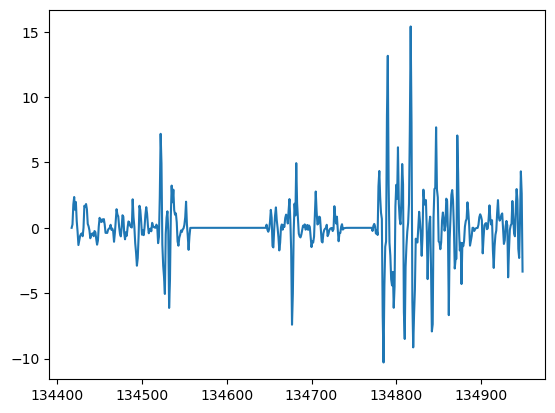

In [52]:
df_ped[df_ped['Track ID']==13429]['ax'].plot()

In [98]:
import numpy as np
import pandas as pd

def detect_mistracks(df, id_col='Track ID'):
    """
    Identifies mistracks using:
    1. Total velocity sign flips (count)
    2. Flip rate (flips per second)
    3. High acceleration instances
    """
    results = []
    
    for ped_id, group in df.groupby(id_col):
        # Time calculations
        timestamps = group['TimeStamp'].values
        duration = timestamps[-1] - timestamps[0] if len(timestamps) > 1 else 0
        
        # Velocity analysis
        vx, vy = group['vx_smooth'].values, group['vy_smooth'].values
        vx_flips = np.sum(np.diff(np.sign(vx)) != 0)
        vy_flips = np.sum(np.diff(np.sign(vy)) != 0)
        total_flips = vx_flips + vy_flips
        flip_rate = total_flips / duration if duration > 0 else 0
        
        # Acceleration analysis
        accel = np.sqrt(group['ax']**2 + group['ay']**2)
        high_accel_count = np.sum(accel > 3.0)  # Count of high acceleration points
        max_accel = np.max(accel)
        
        # Mistrack determination
        is_mistrack = (total_flips > 20) and (flip_rate > 1.2) and (high_accel_count > 8)
        
        results.append({
            id_col: ped_id,
            'total_flips': total_flips,
            'flip_rate': flip_rate,
            'high_accel_count': high_accel_count,
            'max_accel': max_accel,
            'is_mistrack': is_mistrack
        })
    
    return pd.DataFrame(results)

# Usage
mistrack_stats = detect_mistracks(df_ped)

# Get mistracks sorted by severity
mistracks = mistrack_stats[mistrack_stats['is_mistrack']].sort_values(
    ['high_accel_count', 'flip_rate'], 
    ascending=[False, False]
)

print(f"Found {len(mistracks)} potential mistracks:")
print(mistracks)

Found 33 potential mistracks:
     Track ID  total_flips  flip_rate  high_accel_count  max_accel  \
644     10557          150   1.416163               277  95.380417   
750     12361           97   1.353237               198  37.632068   
244      4276           52   1.490826               145  62.193528   
585      9647          144   1.250000                94  38.743134   
428      7530           37   1.256793                81  64.765753   
337      5894           98   1.208087                80  51.349602   
968     15710           53   1.472222                79  39.747737   
649     10800           40   1.381215                71  58.433964   
576      9512           26   1.212687                68  20.090247   
141      2591           43   1.304612                67  20.263775   
453      7820           45   1.358696                63  14.560322   
757     12500           38   1.405325                62  34.927392   
951     15545           70   1.350309                60  30.

In [97]:
import numpy as np
import pandas as pd

def detect_mistracks(df, id_col='Track ID'):
    """
    Identifies mistracks using:
    1. Total velocity sign flips (count)
    2. Flip rate (flips per second)
    3. High acceleration instances
    """
    results = []
    
    for ped_id, group in df.groupby(id_col):
        # Time calculations
        timestamps = group['TimeStamp'].values
        duration = timestamps[-1] - timestamps[0] if len(timestamps) > 1 else 0
        
        # Velocity analysis
        vx, vy = group['vx_smooth'].values, group['vy_smooth'].values
        vx_flips = np.sum(np.diff(np.sign(vx)) != 0)
        vy_flips = np.sum(np.diff(np.sign(vy)) != 0)
        total_flips = vx_flips + vy_flips
        flip_rate = total_flips / duration if duration > 0 else 0
        
        # Acceleration analysis
        accel = np.sqrt(group['ax']**2 + group['ay']**2)
        high_accel_count = np.sum(accel > 8)  # Count of high acceleration points
        max_accel = np.max(accel)
        
        # Mistrack determination
        is_mistrack = (total_flips > 30) and (flip_rate > 1.2) and (high_accel_count > 8)
        
        results.append({
            id_col: ped_id,
            'total_flips': total_flips,
            'flip_rate': flip_rate,
            'high_accel_count': high_accel_count,
            'max_accel': max_accel,
            'is_mistrack': is_mistrack
        })
    
    return pd.DataFrame(results)

# Usage
mistrack_stats = detect_mistracks(df_moto)

# Get mistracks sorted by severity
mistracks2 = mistrack_stats[mistrack_stats['is_mistrack']].sort_values(
    ['high_accel_count', 'flip_rate'], 
    ascending=[False, False]
)

print(f"Found {len(mistracks2)} potential mistracks2:")
print(mistracks2)

Found 2 potential mistracks2:
      Track ID  total_flips  flip_rate  high_accel_count   max_accel  \
1269      7002           48   1.321586                80  175.842867   
2644     14617           48   1.209677                27   45.281885   

      is_mistrack  
1269         True  
2644         True  


In [130]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist

# Parameters
SPEED_THRESHOLD = 0.5  # m/s
MIN_STOP_DURATION = 1.0  # seconds
DIST_THRESH = 0.9882433
EXPORT_INTERVAL = 0.16  # seconds

def filter_stopped_vehicles(df, speed_col='speed', time_col='TimeStamp'):
    """Filter out periods where vehicles are stopped for more than MIN_STOP_DURATION"""
    df = df.copy()
    df['time_diff'] = df.groupby('Track ID')[time_col].diff()
    df['is_stopped'] = df[speed_col] < SPEED_THRESHOLD
    stop_groups = (df['is_stopped'] != df['is_stopped'].shift()).cumsum()
    df['stop_duration'] = df.groupby(['Track ID', stop_groups])['time_diff'].cumsum()
    filtered_df = df[~((df['is_stopped']) & (df['stop_duration'] >= MIN_STOP_DURATION))]
    return filtered_df.drop(columns=['time_diff', 'is_stopped', 'stop_duration'])

# Load and filter data
df_ped = pd.read_csv(r"D:\T\test_codeEVT\nd\ped_smooth.csv")
# df_ped=df_ped[(df_ped['ax']<8.5) & (df_ped['ay']<8.5)]
df_moto = pd.read_csv(r"D:\T\test_codeEVT\nd\moto_smooth.csv")
# df_moto=df_moto[(df_moto['ax']<5) & (df_moto['ay']<5)]
df_moto=df_moto[~df_moto['Track ID'].isin(mistracks2['Track ID'])]

df_moto['speed']=(df_moto['vx_smooth']**2+df_moto['vy_smooth']**2)**0.5

print(f"Original motorcycle count: {len(df_moto)}")
df_moto = filter_stopped_vehicles(df_moto, speed_col='speed')
print(f"Filtered motorcycle count: {len(df_moto)}")

# Calculate yaw rates (first entry per Track ID will be NaN)
for df in [df_ped, df_moto]:
    df['yaw_rate'] = df.groupby('Track ID').apply(
        lambda x: x['HA'].diff() / x['TimeStamp'].diff()
    ).reset_index(level=0, drop=True)

# Round timestamps
df_ped['Time_rounded'] = (df_ped['TimeStamp'] / EXPORT_INTERVAL).round() * EXPORT_INTERVAL
df_moto['Time_rounded'] = (df_moto['TimeStamp'] / EXPORT_INTERVAL).round() * EXPORT_INTERVAL

# Vectorized temporal matching
merged = pd.merge(
    df_ped, 
    df_moto, 
    on='Time_rounded', 
    suffixes=('_ped', '_moto')
)

# Vectorized center-distance calculation
merged['Center_dist'] = np.hypot(
    merged['x_smooth_ped'] - merged['x_smooth_moto'],
    merged['y_smooth_ped'] - merged['y_smooth_moto']
)

# Vectorized corner-distance calculation
def get_min_corner_distance(row, ped_box=(0.3, 0.3), moto_box=(1.87, 0.64)):
    ped_corners = get_rotated_corners(
        row['x_smooth_ped'], row['y_smooth_ped'],
        row['HA_ped'], *ped_box
    )
    moto_corners = get_rotated_corners(
        row['x_smooth_moto'], row['y_smooth_moto'],
        row['HA_moto'], *moto_box
    )
    return cdist(ped_corners, moto_corners).min()

# Vectorized ATTC calculation
def calculate_attc(row):
    # Position vectors
    r_ped = np.array([row['x_smooth_ped'], row['y_smooth_ped']])
    r_moto = np.array([row['x_smooth_moto'], row['y_smooth_moto']])
    
    # Relative position and derivatives
    delta_r = r_ped - r_moto
    distance = np.linalg.norm(delta_r)
    
    if distance == 0:
        return np.inf
    
    # Velocity vectors
    v_ped = np.array([row['vx_smooth_ped'], row['vy_smooth_ped']])
    v_moto = np.array([row['vx_smooth_moto'], row['vy_smooth_moto']])
    delta_v = v_ped - v_moto
    
    # Acceleration vectors
    a_ped = np.array([row['ax_ped'], row['ay_ped']])
    a_moto = np.array([row['ax_moto'], row['ay_moto']])
    delta_a = a_ped - a_moto
    
    # Steering effects (using yaw rates)
    yaw_ped = row.get('yaw_rate_ped', 0)  # rad/s
    yaw_moto = row.get('yaw_rate_moto', 0)
    delta_yaw = yaw_ped - yaw_moto
    
    # Unit vector in direction of line of sight
    u = delta_r / distance
    
    # Closing rate components
    vel_component = -np.dot(delta_v, u)
    acc_component = np.dot(delta_a, u) * 0.2  # 0.5s prediction
    steering_component = delta_yaw * distance * 0  # Empirical factor
    
    # Combined closing rate
    closing_rate = vel_component + acc_component + steering_component
    
    # Minimum corner distance (pre-calculated)
    min_dist = row['Min_Corner_Distance'] 
    
    # Final ATTC
    if closing_rate > 0:
        return min_dist / closing_rate
    else:
        return np.inf

# Apply filters and calculations
results = merged[merged['Center_dist'] <= DIST_THRESH].copy()
results['Min_Corner_Distance'] = results.apply(get_min_corner_distance, axis=1)
results['ATTC'] = results.apply(calculate_attc, axis=1)

# Final output
output = results[['Track ID_ped', 'Track ID_moto', 'TimeStamp_ped', 
                 'Min_Corner_Distance', 'ATTC']].rename(columns={
                     'Track ID_ped': 'Ped_ID',
                     'Track ID_moto': 'Moto_ID',
                     'TimeStamp_ped': 'TimeStamp'
                 })
print(output)

Original motorcycle count: 306787
Filtered motorcycle count: 199619


C:\Users\IST LAB 1\AppData\Local\Temp\ipykernel_13628\2752989819.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['yaw_rate'] = df.groupby('Track ID').apply(
C:\Users\IST LAB 1\AppData\Local\Temp\ipykernel_13628\2752989819.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['yaw_rate'] = df.groupby('Track ID').apply(


        Ped_ID  Moto_ID  TimeStamp  Min_Corner_Distance      ATTC
4626       282      302     106.84             0.264678  0.262128
4659       282      302     107.16             0.504374       inf
4660       282      302     107.16             0.683216       inf
10689      369      339     118.88             0.836823  1.104078
10700      369      339     119.04             0.660417       inf
...        ...      ...        ...                  ...       ...
890648   15693    15756    5403.64             0.626890  0.828996
890658   15693    15756    5403.80             0.528965  1.145349
890670   15693    15756    5403.96             0.457913       inf
890680   15693    15756    5404.12             0.380723       inf
890691   15693    15756    5404.28             0.271031       inf

[4872 rows x 5 columns]


In [131]:
unique_pairs = output[['Ped_ID', 'Moto_ID']].drop_duplicates()
print(f"\nNumber of unique Ped_ID-Moto_ID pairs Before ATTC check: {len(unique_pairs)}")
dangerous_pairs = output[output['ATTC'] < 1][['Ped_ID', 'Moto_ID']].drop_duplicates()
print(f"\nNumber of unique Ped_ID-Moto_ID pairs with ATTC < 1: {len(dangerous_pairs)}")
print("\nDangerous pairs (ATTC < 1):")
print(dangerous_pairs)


Number of unique Ped_ID-Moto_ID pairs Before ATTC check: 523

Number of unique Ped_ID-Moto_ID pairs with ATTC < 1: 348

Dangerous pairs (ATTC < 1):
        Ped_ID  Moto_ID
4626       282      302
10847      369      367
11097      369      390
13190      382      390
13385      382      399
...        ...      ...
888931   15650    15684
889533   15693    15624
889556   15693    15716
889563   15693    15684
890418   15693    15756

[348 rows x 2 columns]


In [180]:
# Load data
df_ped = pd.read_csv(r"C:\Users\Tusha\Visual Studio Codes\test_codeEVT\smoothen_data/ped_smooth.csv")
df_SmTr = pd.read_csv(r"C:\Users\Tusha\Visual Studio Codes\test_codeEVT\smoothen_data\LightTruck_smooth.csv")
min_stop_duration = 1.0  # seconds
speed_threshold = 0.2  # m/s (adjust based on sensor noise)

# 1. Calculate time differences within each track
df_SmTr['time_diff'] = df_SmTr.groupby('Track ID')['TimeStamp'].diff()

# 2. Identify stop segments (where speed < threshold)
df_SmTr['is_stopped'] = df_SmTr['speed'] < speed_threshold

# 3. Group consecutive stops and calculate cumulative stop duration
stop_groups = (df_SmTr['is_stopped'] != df_SmTr['is_stopped'].shift()).cumsum()
df_SmTr['stop_duration'] = df_SmTr.groupby(['Track ID', stop_groups])['time_diff'].cumsum()

# 4. Filter out only sustained stops (>1 second)
filtered_df = df_SmTr[~((df_SmTr['is_stopped']) & (df_SmTr['stop_duration'] >= min_stop_duration))]

print(f"Original rows: {len(df_SmTr)}")
print(f"Filtered rows: {len(filtered_df)}")
df_SmTr=filtered_df

DIST_THRESH_SmallTruck = 2.5  # meters
TIME_THRESH = 0.5   # seconds (changed from 1.0 to 5.0)

# Storage for unique pairs
interaction_pairs = set()

# Process each pedestrian
for ped_id in df_ped['Track ID'].unique():
    # Get smoothed coordinates and timestamps
    ped_data = df_ped[df_ped['Track ID'] == ped_id]
    ped_points = ped_data[['x_smooth', 'y_smooth', 'TimeStamp']].values
    
    # Time window for active cars
    time_min = ped_points[:,2].min() - TIME_THRESH
    time_max = ped_points[:,2].max() + TIME_THRESH
    active_smtr = df_SmTr[(df_SmTr['TimeStamp'] >= time_min) & 
                         (df_SmTr['TimeStamp'] <= time_max)]
    
    if not active_smtr.empty:
        # Build KDTree with smoothed coordinates
        moto_points = active_smtr[['x_smooth', 'y_smooth', 'TimeStamp']].values
        tree = cKDTree(moto_points[:,:2])  # Only x_smooth and y_smooth
        
        # Check each pedestrian point
        for ped_x, ped_y, ped_time in ped_points:
            # Find nearby cars (within 3.5m)
            distances, indices = tree.query(
                [ped_x, ped_y],
                distance_upper_bound=DIST_THRESH_SmallTruck,
                k=10  # Check up to 10 nearest cars
            )
            
            # Verify time proximity (within 5s)
            for dist, idx in zip(distances, indices):
                if dist < DIST_THRESH_SmallTruck:
                    smtr_time = moto_points[idx,2]
                    if abs(smtr_time - ped_time) <= TIME_THRESH:
                        Smtr_id = active_smtr.iloc[idx]['Track ID']
                        interaction_pairs.add((ped_id, Smtr_id))

# Create result DataFrame
result = pd.DataFrame(
    sorted(interaction_pairs),
    columns=['Pedestrian_ID', 'SmallTruck_ID']
)

print(f"Found {len(result)} unique interaction pairs")
# result.to_csv("ped_car_interactions.csv", index=False)
print(result.head(10))

Original rows: 51965
Filtered rows: 30778
Found 80 unique interaction pairs
   Pedestrian_ID  SmallTruck_ID
0            369            352
1           1168           1200
2           1285           1340
3           1524           1496
4           1569           1549
5           1660           1654
6           1692           1819
7           1692           1835
8           2310           2462
9           2770           2667


In [198]:
# Load data
df_ped = pd.read_csv(r"C:\Users\Tusha\Visual Studio Codes\test_codeEVT\smoothen_data/ped_smooth.csv")
df_Bus = pd.read_csv(r"C:\Users\Tusha\Visual Studio Codes\test_codeEVT\smoothen_data\bus_smooth.csv")
min_stop_duration = 1.0  # seconds
speed_threshold = 0.2  # m/s (adjust based on sensor noise)

# 1. Calculate time differences within each track
df_Bus['time_diff'] = df_Bus.groupby('Track ID')['TimeStamp'].diff()

# 2. Identify stop segments (where speed < threshold)
df_Bus['is_stopped'] = df_Bus['speed'] < speed_threshold

# 3. Group consecutive stops and calculate cumulative stop duration
stop_groups = (df_Bus['is_stopped'] != df_Bus['is_stopped'].shift()).cumsum()
df_Bus['stop_duration'] = df_Bus.groupby(['Track ID', stop_groups])['time_diff'].cumsum()

# 4. Filter out only sustained stops (>1 second)
filtered_df = df_Bus[~((df_Bus['is_stopped']) & (df_Bus['stop_duration'] >= min_stop_duration))]

print(f"Original rows: {len(df_Bus)}")
print(f"Filtered rows: {len(filtered_df)}")
df_Bus=filtered_df

DIST_THRESH_SmallTruck = 1.7  # meters
TIME_THRESH = 0.5   # seconds (changed from 1.0 to 5.0)

# Storage for unique pairs
interaction_pairs = set()

# Process each pedestrian
for ped_id in df_ped['Track ID'].unique():
    # Get smoothed coordinates and timestamps
    ped_data = df_ped[df_ped['Track ID'] == ped_id]
    ped_points = ped_data[['x_smooth', 'y_smooth', 'TimeStamp']].values
    
    # Time window for active cars
    time_min = ped_points[:,2].min() - TIME_THRESH
    time_max = ped_points[:,2].max() + TIME_THRESH
    active_bus = df_Bus[(df_Bus['TimeStamp'] >= time_min) & 
                         (df_Bus['TimeStamp'] <= time_max)]
    
    if not active_bus.empty:
        # Build KDTree with smoothed coordinates
        Bus_points = active_bus[['x_smooth', 'y_smooth', 'TimeStamp']].values
        tree = cKDTree(Bus_points[:,:2])  # Only x_smooth and y_smooth
        
        # Check each pedestrian point
        for ped_x, ped_y, ped_time in ped_points:
            # Find nearby cars (within 3.5m)
            distances, indices = tree.query(
                [ped_x, ped_y],
                distance_upper_bound=DIST_THRESH_SmallTruck,
                k=10  # Check up to 10 nearest cars
            )
            
            # Verify time proximity (within 5s)
            for dist, idx in zip(distances, indices):
                if dist < DIST_THRESH_SmallTruck:
                    Bus_time = Bus_points[idx,2]
                    if abs(Bus_time - ped_time) <= TIME_THRESH:
                        Bus_id = active_bus.iloc[idx]['Track ID']
                        interaction_pairs.add((ped_id, Bus_id))

# Create result DataFrame
result = pd.DataFrame(
    sorted(interaction_pairs),
    columns=['Pedestrian_ID', 'Bus_ID']
)

print(f"Found {len(result)} unique interaction pairs")
# result.to_csv("ped_car_interactions.csv", index=False)
print(result.head(10))

Original rows: 14925
Filtered rows: 8192
Found 4 unique interaction pairs
   Pedestrian_ID  Bus_ID
0           5556    5610
1           9253    9326
2          10279   10291
3          14522   14310



Processing  Bicycle interactions...
Found 0 pedestrian- Bicycle interaction pairs

Processing  Bus interactions...
Found 8 pedestrian- Bus interaction pairs

Processing  Car interactions...
Found 147 pedestrian- Car interaction pairs

Processing  Light Truck interactions...
Found 57 pedestrian- Light Truck interaction pairs

Processing  Motorcycle interactions...
Found 461 pedestrian- Motorcycle interaction pairs

Processing  Tractor interactions...
Found 1 pedestrian- Tractor interaction pairs

Processing  Tuk-Tuk interactions...
Found 324 pedestrian- Tuk-Tuk interaction pairs

Processing  Van interactions...
Found 1 pedestrian- Van interaction pairs

=== Interaction Summary ===
Pedestrian vs  Bicycle: 0 conflicts
Pedestrian vs  Bus: 8 conflicts
Pedestrian vs  Car: 147 conflicts
Pedestrian vs  Light Truck: 57 conflicts
Pedestrian vs  Motorcycle: 461 conflicts
Pedestrian vs  Tractor: 1 conflicts
Pedestrian vs  Tuk-Tuk: 324 conflicts
Pedestrian vs  Van: 1 conflicts

TOTAL CONFLICTS ACR

In [2]:
import pandas as pd
import numpy as np
from scipy.spatial import distance
import math

# Configuration
MERGED_DATA_PATH =r"D:\T\test_codeEVT\nd\merged_data.csv"
PEDESTRIAN_TYPE = " Pedestrian"
VEHICLE_TYPES = {
    ' Bicycle': (1.90, 0.45),
    ' Bus': (10.10, 2.43),
    ' Car': (3.72, 1.44),
    ' Light Truck': (6.10, 2.10),
    ' Motorcycle': (1.87, 0.64),
    ' Tractor': (3.40, 1.85),
    ' Tuk-Tuk': (3.20, 1.40),
    ' Van': (4.48, 1.80)
}

# Constants
TIME_THRESH = 0.5       # ±0.5s
FINAL_DIST = 0.6        # Corner-to-corner distance (m)
MIN_SPEED = 4.0         # Minimum vehicle speed (m/s)
PED_WIDTH = 0.3         # Pedestrian width (m)
# LATERAL_CLEARANCE = 1 # Safety buffer (m)
PED_BOX = (0.3, 0.3)    # Pedestrian dimensions (length, width)

def get_corners(x, y, vx, vy, box):
    """Calculate rotated bounding box corners"""
    angle = np.arctan2(vy, vx)
    half_l, half_w = box[0]/2, box[1]/2
    rot = np.array([[np.cos(angle), -np.sin(angle)],
                   [np.sin(angle), np.cos(angle)]])
    corners = np.array([[half_l, half_w], [half_l, -half_w],
                       [-half_l, -half_w], [-half_l, half_w]])
    return corners @ rot.T + np.array([x, y])

def get_cc_threshold(vehicle_width,veh_length):
    """Calculate dynamic center-to-center threshold"""
    return (math.sqrt((veh_width/2)**2 +(veh_length/2)**2)+math.sqrt(2*(PED_WIDTH/2)**2))

print("=== Loading Merged Data ===")
df = pd.read_csv(MERGED_DATA_PATH)
print(f"Total records: {len(df)}")
print(f"Vehicle types detected: {df[df['Type'] != PEDESTRIAN_TYPE]['Type'].unique()}")

# Filter stopped vehicles
print("\n=== Filtering Stopped Vehicles ===")
df_vehicles = df[df['Type'] != PEDESTRIAN_TYPE].copy()
df_vehicles['time_diff'] = df_vehicles.groupby('Track ID')['TimeStamp'].diff()
df_vehicles['is_stopped'] = df_vehicles['speed'] < 0.08
stop_groups = (df_vehicles['is_stopped'] != df_vehicles['is_stopped'].shift()).cumsum()
df_vehicles['stop_duration'] = df_vehicles.groupby(['Track ID', stop_groups])['time_diff'].cumsum()
active_vehicles = df_vehicles[~((df_vehicles['is_stopped']) & (df_vehicles['stop_duration'] >= 1.0))]
print(f"Active vehicles after filtering: {len(active_vehicles)}/{len(df_vehicles)}")

# Get pedestrians and handle zero speed cases
df_ped = df[df['Type'] == PEDESTRIAN_TYPE].copy()
# Calculate speed magnitude
df_ped['speed_mag'] = np.sqrt(df_ped['vx']**2 + df_ped['vy']**2)
# For zero speed cases, use previous heading angle
df_ped['prev_vx'] = df_ped.groupby('Track ID')['vx'].shift()
df_ped['prev_vy'] = df_ped.groupby('Track ID')['vy'].shift()
zero_speed_mask = df_ped['speed_mag'] < 0.01  # threshold for "at rest"
df_ped.loc[zero_speed_mask, 'vx'] = df_ped.loc[zero_speed_mask, 'prev_vx']
df_ped.loc[zero_speed_mask, 'vy'] = df_ped.loc[zero_speed_mask, 'prev_vy']
print(f"\nPedestrians to analyze: {len(df_ped)}")

print("\n=== Processing Near-Misses ===")
results = {veh_type: 0 for veh_type in VEHICLE_TYPES}
detailed_results = []

for ped_idx, (_, ped) in enumerate(df_ped.iterrows()):
    if (ped_idx + 1) % 100 == 0 or (ped_idx + 1) == len(df_ped):
        print(f"Analyzing pedestrian {ped_idx + 1}/{len(df_ped)} (ID: {ped['Track ID']})")

    # Temporal proximity check
    time_mask = (active_vehicles['TimeStamp'] >= ped['TimeStamp'] - TIME_THRESH) & \
               (active_vehicles['TimeStamp'] <= ped['TimeStamp'] + TIME_THRESH)
    nearby_vehicles = active_vehicles[time_mask]

    for _, veh in nearby_vehicles.iterrows():
        if veh['Type'] not in VEHICLE_TYPES:
            continue

        # Dynamic center-to-center threshold
        veh_width = VEHICLE_TYPES[veh['Type']][1]
        veh_length = VEHICLE_TYPES[veh['Type']][0]
        cc_threshold = get_cc_threshold(veh_width,veh_length)

        # Spatial proximity check with dynamic threshold
        center_dist = np.hypot(veh['X']-ped['X'], veh['Y']-ped['Y'])
        if center_dist > cc_threshold:
            continue

        # Speed check
        if veh['speed'] <= MIN_SPEED:
            continue

        # Precise corner check
        veh_box = VEHICLE_TYPES[veh['Type']]
        ped_corners = get_corners(ped['X'], ped['Y'], ped['vx'], ped['vy'], PED_BOX)
        veh_corners = get_corners(veh['X'], veh['Y'], veh['vx'], veh['vy'], veh_box)

        min_dist = distance.cdist(ped_corners, veh_corners).min()
        if min_dist <= FINAL_DIST:
            results[veh['Type']] += 1
            detailed_results.append({
                'Ped_ID': ped['Track ID'],
                'Vehicle_Type': veh['Type'],
                'Vehicle_ID': veh['Track ID'],
                'Time': ped['TimeStamp'],
                'Min_Distance': min_dist,
                'CC_Threshold': cc_threshold,
                'Vehicle_Width': veh_width,
                'Ped_X': ped['X'],
                'Ped_Y': ped['Y'],
                'Vehicle_X': veh['X'],
                'Vehicle_Y': veh['Y']
            })
            print(f"  ! Near-miss: Ped {ped['Track ID']} with {veh['Type']} {veh['Track ID']} "
                  f"(Distance: {min_dist:.2f}m, CC Threshold: {cc_threshold:.2f}m at {ped['TimeStamp']:.1f}s)")
            break

print("\n=== Summary Results ===")
for veh_type, count in results.items():
    veh_width = VEHICLE_TYPES[veh_type][1]
    veh_length = VEHICLE_TYPES[veh_type][0]
    cc_thresh = get_cc_threshold(veh_width,veh_length)
    print(f"Total {veh_type} near-misses (width: {veh_width}m,length: {veh_length}m, CC threshold: {cc_thresh:.2f}m): {count}")

if detailed_results:
    results_df = pd.DataFrame(detailed_results)
    print("\n=== Detailed Near-Miss Events ===")
    print(results_df[['Ped_ID', 'Vehicle_Type', 'Vehicle_ID', 'Min_Distance', 'CC_Threshold', 'Time']].head())
else:
    print("\nNo near-miss events detected")

=== Loading Merged Data ===
Total records: 1245461
Vehicle types detected: [' Bicycle' ' Bus' ' Car' ' Light Truck' ' Motorcycle' ' Tractor'
 ' Tuk-Tuk' ' Van']

=== Filtering Stopped Vehicles ===
Active vehicles after filtering: 687419/1086324

Pedestrians to analyze: 159137

=== Processing Near-Misses ===
Analyzing pedestrian 100/159137 (ID: 170)
Analyzing pedestrian 200/159137 (ID: 201)
Analyzing pedestrian 300/159137 (ID: 201)
Analyzing pedestrian 400/159137 (ID: 201)
Analyzing pedestrian 500/159137 (ID: 201)
Analyzing pedestrian 600/159137 (ID: 215)
Analyzing pedestrian 700/159137 (ID: 215)
Analyzing pedestrian 800/159137 (ID: 233)
Analyzing pedestrian 900/159137 (ID: 233)
Analyzing pedestrian 1000/159137 (ID: 269)
Analyzing pedestrian 1100/159137 (ID: 269)
Analyzing pedestrian 1200/159137 (ID: 282)
  ! Near-miss: Ped 292 with  Motorcycle 299 (Distance: 0.42m, CC Threshold: 1.20m at 101.8s)
  ! Near-miss: Ped 292 with  Motorcycle 299 (Distance: 0.46m, CC Threshold: 1.20m at 102.0s

In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
from tqdm import tqdm

# ==============================
# PARAMETERS
# ==============================
EXPORT_INTERVAL = 0.16          # Frame rate (seconds)
DIST_THRESH = 1.200              # Distance threshold for potential conflict (meters)
PED_BOX = (0.3, 0.3)            # Pedestrian bounding box (length, width in meters)
MOTO_BOX = (1.87, 0.64)         # Motorcycle bounding box
SPEED_THRESHOLD = 4           # Minimum speed (m/s) to be considered "moving"
MIN_STOP_DURATION = 1.0         # Duration threshold to define "stopped" vehicles (seconds)

# ==============================
# STEP 1: LOAD DATA
# ==============================
df_ped = pd.read_csv(r"D:\T\test_codeEVT\nd\ped_smooth.csv")
df_moto = pd.read_csv(r"D:\T\test_codeEVT\nd\moto_smooth.csv")

# ==============================
# STEP 2: FILTER OUT STOPPED MOTORCYCLES
# ==============================
# Compute motorcycle speed
df_moto['speed'] = np.sqrt(df_moto['vx_smooth']**2 + df_moto['vy_smooth']**2)

# Filter function
def filter_stopped_vehicles(df, speed_col='speed', time_col='TimeStamp'):
    df = df.copy()
    df['time_diff'] = df.groupby('Track ID')[time_col].diff()
    df['is_stopped'] = df[speed_col] < SPEED_THRESHOLD
    stop_groups = (df['is_stopped'] != df['is_stopped'].shift()).cumsum()
    df['stop_duration'] = df.groupby(['Track ID', stop_groups])['time_diff'].cumsum()
    filtered_df = df[~((df['is_stopped']) & (df['stop_duration'] >= MIN_STOP_DURATION))]
    return filtered_df.drop(columns=['time_diff', 'is_stopped', 'stop_duration'])

df_moto = filter_stopped_vehicles(df_moto)

# ==============================
# STEP 3: PREPROCESSING
# - Round timestamps
# - Compute heading from smoothed velocity
# ==============================
df_ped['TimeStamp_rounded'] = np.round(df_ped['TimeStamp'] / EXPORT_INTERVAL) * EXPORT_INTERVAL
df_moto['TimeStamp_rounded'] = np.round(df_moto['TimeStamp'] / EXPORT_INTERVAL) * EXPORT_INTERVAL
df_ped['heading'] = np.degrees(np.arctan2(df_ped['vy_smooth'], df_ped['vx_smooth'])) % 360
df_moto['heading'] = np.degrees(np.arctan2(df_moto['vy_smooth'], df_moto['vx_smooth'])) % 360

# ==============================
# STEP 4: FUNCTION - GET ROTATED BOUNDING BOX CORNERS
# ==============================
def get_all_rotated_corners(df, box_dim):
    half_l, half_w = box_dim[0] / 2, box_dim[1] / 2
    base_corners = np.array([
        [half_l, half_w],
        [half_l, -half_w],
        [-half_l, -half_w],
        [-half_l, half_w]
    ])
    headings_rad = np.radians(df['heading'].values)
    cos = np.cos(headings_rad)
    sin = np.sin(headings_rad)

    rotated = np.empty((len(df), 4, 2))
    for i in range(4):
        x = base_corners[i, 0]
        y = base_corners[i, 1]
        rotated[:, i, 0] = x * cos - y * sin + df['x_smooth'].values
        rotated[:, i, 1] = x * sin + y * cos + df['y_smooth'].values
    return rotated

# ==============================
# STEP 5: PAIRWISE CONFLICT DETECTION
# - For each pedestrian-motorcycle pair:
#     - Align timestamps
#     - Check center distance
#     - Calculate minimum corner distance
#     - Compute closing rate and ATTC
# ==============================
conflict_rows = []
ped_ids = df_ped['Track ID'].unique()
moto_ids = df_moto['Track ID'].unique()

for ped_id in tqdm(ped_ids, desc="Processing pedestrian–motorcycle pairs"):
    ped = df_ped[df_ped['Track ID'] == ped_id].copy()
    ped_corners_all = get_all_rotated_corners(ped, PED_BOX)
    ped_times = ped['TimeStamp_rounded'].values
    ped_xy = ped[['x_smooth', 'y_smooth']].values

    for moto_id in moto_ids:
        moto = df_moto[df_moto['Track ID'] == moto_id].copy()
        moto_corners_all = get_all_rotated_corners(moto, MOTO_BOX)
        moto_times = moto['TimeStamp_rounded'].values
        moto_xy = moto[['x_smooth', 'y_smooth']].values

        # Exact timestamp matches only
        time_diffs = np.abs(ped_times[:, None] - moto_times[None, :])
        time_matches = time_diffs <= 0.0

        # Euclidean distance between centers
        center_dists = np.hypot(
            ped_xy[:, 0, None] - moto_xy[None, :, 0],
            ped_xy[:, 1, None] - moto_xy[None, :, 1]
        )

        conflict_mask = (time_matches) & (center_dists <= DIST_THRESH)
        ped_idx, moto_idx = np.where(conflict_mask)

        for p_idx, m_idx in zip(ped_idx, moto_idx):
            ped_row = ped.iloc[p_idx]
            moto_row = moto.iloc[m_idx]
            min_dist = cdist(ped_corners_all[p_idx], moto_corners_all[m_idx]).min()

            if min_dist == 0:
                closing_rate = 0
            else:
                dist_matrix = cdist(ped_corners_all[p_idx], moto_corners_all[m_idx])
                min_idx = np.unravel_index(np.argmin(dist_matrix), dist_matrix.shape)
                direction_vec = moto_corners_all[m_idx][min_idx[1]] - ped_corners_all[p_idx][min_idx[0]]
                unit_vec = direction_vec / min_dist

                rel_v = np.array([
                    ped_row['vx_smooth'] - moto_row['vx_smooth'],
                    ped_row['vy_smooth'] - moto_row['vy_smooth']
                ])
                rel_a = 0.5 * np.array([
                    ped_row['ax'] - moto_row['ax'],
                    ped_row['ay'] - moto_row['ay']
                ])

                closing_rate = -np.dot(rel_v, unit_vec) + np.dot(rel_a, unit_vec)

            attc = min_dist / closing_rate if closing_rate > 0 else np.inf

            conflict_rows.append({
                'Ped_ID': ped_id,
                'Moto_ID': moto_id,
                'Ped_Time': ped_row['TimeStamp'],
                'Moto_Time': moto_row['TimeStamp'],
                'Ped_X': ped_row['x_smooth'],
                'Ped_Y': ped_row['y_smooth'],
                'Moto_X': moto_row['x_smooth'],
                'Moto_Y': moto_row['y_smooth'],
                'Min_Corner_Distance': min_dist,
                'Closing_Rate': closing_rate,
                'ATTC': attc,
                'Ped_Heading': ped_row['heading'],
                'Moto_Heading': moto_row['heading']
            })

# ==============================
# STEP 6: EXPORT FINAL RESULTS
# ==============================
results_df = pd.DataFrame(conflict_rows)
print(results_df.head())
results_df.to_csv("ped_moto_attc_results.csv", index=False)


Processing pedestrian–motorcycle pairs: 100%|██████████| 1019/1019 [21:07<00:00,  1.24s/it]

   Ped_ID  Moto_ID  Ped_Time  Moto_Time          Ped_X         Ped_Y  \
0     282      302    106.52     106.64  778879.944577  1.435739e+06   
1     282      302    106.84     106.80  778879.383578  1.435738e+06   
2     282      302    106.84     106.96  778879.383578  1.435738e+06   
3     282      302    107.16     107.12  778878.971203  1.435738e+06   
4     282      302    107.16     107.28  778878.971203  1.435738e+06   

          Moto_X        Moto_Y  Min_Corner_Distance  Closing_Rate      ATTC  \
0  778881.034641  1.435738e+06             0.183095     -2.252007       inf   
1  778880.414878  1.435739e+06             0.152890     -2.040113       inf   
2  778879.869132  1.435739e+06             0.264678      3.288430  0.080488   
3  778879.512348  1.435739e+06             0.504374      3.268433  0.154317   
4  778879.277183  1.435739e+06             0.683216      1.600772  0.426804   

   Ped_Heading  Moto_Heading  
0   214.061120    174.166831  
1   212.581404    175.489484  

In [27]:
results_df

,Ped_ID,Moto_ID,Ped_Time,Moto_Time,Ped_X,Ped_Y,Moto_X,Moto_Y,Min_Corner_Distance,Closing_Rate,ATTC,Ped_Heading,Moto_Heading
0,282,302,106.52,106.64,778879.944577,1.435739e+06,778881.034641,1.435738e+06,0.183095,-2.252007,inf,214.061120,174.166831
1,282,302,106.84,106.80,778879.383578,1.435738e+06,778880.414878,1.435739e+06,0.152890,-2.040113,inf,212.581404,175.489484
2,282,302,106.84,106.96,778879.383578,1.435738e+06,778879.869132,1.435739e+06,0.264678,3.288430,0.080488,212.581404,176.098905
3,282,302,107.16,107.12,778878.971203,1.435738e+06,778879.512348,1.435739e+06,0.504374,3.268433,0.154317,233.933089,175.740075
4,282,302,107.16,107.28,778878.971203,1.435738e+06,778879.277183,1.435739e+06,0.683216,1.600772,0.426804,233.933089,177.528323
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1511,15693,15756,5396.76,5396.84,778895.219412,1.435732e+06,778895.583336,1.435732e+06,0.528405,-1.653728,inf,163.400740,35.311246
1512,15693,15756,5396.92,5397.00,778895.164072,1.435732e+06,778895.612384,1.435732e+06,0.512654,-1.262862,inf,153.436388,37.613928
1513,15693,15756,5397.08,5397.16,778895.136753,1.435732e+06,778895.611111,1.435732e+06,0.507103,0.262425,1.932371,133.182188,94.938229
1514,15693,15756,5397.24,5397.32,778895.126318,1.435732e+06,778895.592084,1.435732e+06,0.268971,-0.615658,inf,109.382631,136.611784


In [28]:
results_df[results_df['ATTC']>1].count()

Ped_ID                 1059
Moto_ID                1059
Ped_Time               1059
Moto_Time              1059
Ped_X                  1059
Ped_Y                  1059
Moto_X                 1059
Moto_Y                 1059
Min_Corner_Distance    1059
Closing_Rate            892
ATTC                   1059
Ped_Heading            1059
Moto_Heading           1059
dtype: int64

In [33]:
output= results_df[(results_df['Min_Corner_Distance']<1) & (results_df['ATTC']<1)]
unique_pairs = output[['Ped_ID', 'Moto_ID']].drop_duplicates()
print(f"\nNumber of unique Ped_ID-Moto_ID pairs: {len(unique_pairs)}")
print(unique_pairs[['Ped_ID', 'Moto_ID']])



Number of unique Ped_ID-Moto_ID pairs: 200
      Ped_ID  Moto_ID
2        282      302
21       391      390
26       391      411
28       415      446
31       417      433
...      ...      ...
1491   15597    15684
1497   15602    15624
1502   15650    15724
1505   15693    15716
1509   15693    15756

[200 rows x 2 columns]


Empty DataFrame
Columns: [Ped_Time, ATTC, Min_Corner_Distance]
Index: []


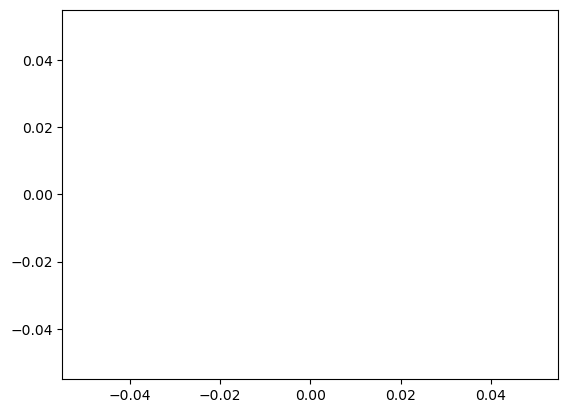

In [25]:
p=results_df[results_df['Ped_ID']==408]
p['ATTC'].plot()
print(p[['Ped_Time', 'ATTC','Min_Corner_Distance']])